# Performance comparaison

| Fingerprint | R2 | RMSE |  
|:-:|:-:|:-:|  
| ECFP| 0.765 | 0.9808 |
|Can2Can|0.7176|1.073|
| NFP| 0.8845 | 0.6868 |

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys, AllChem

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df_sol = pd.read_csv('../data/solubility.csv')
df_sol.head()

,SMILES,unknown,solubility,processed_smiles
0,O=C(C)N,60-35-5,1.58,O = C ( C ) N
1,NNC,60-34-4,1.34,N N C
2,O=C(C)O,64-19-7,1.22,O = C ( C ) O
3,N1CCCC1,123-75-1,1.15,N 1 C C C C 1
4,O=C(N)NO,127-07-1,1.12,O = C ( N ) N O


# Solubility regression

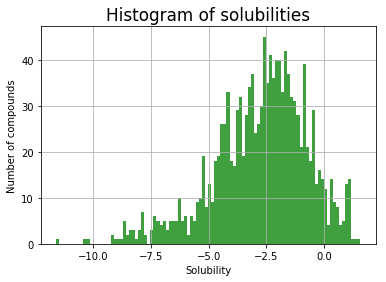

In [3]:
sol = df_sol['solubility'].values 
plt.hist(sol, 100, facecolor='green', alpha=0.75)
plt.rcParams["font.size"]=14
plt.xlabel('Solubility')
plt.ylabel('Number of compounds')
plt.title('Histogram of solubilities')
plt.grid()
plt.show()

In [4]:
def bit2np(bitvector):
    bitstring = bitvector.ToBitString()
    intmap = map(int, bitstring)
    return np.array(list(intmap))

In [5]:
def extract_morgan(df):
    smiles = df["SMILES"].values
    sol = df['solubility'].values
    N = len(smiles)
    print("{} molecules".format(N))
    X,y = [],[]
    for i in range(N):
        mol = Chem.MolFromSmiles(smiles[i])
        if mol is None:
            print(i)
            continue

        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) # Morgan (Similar to ECFP4)
        X.append(bit2np(fp))
        y.append(sol[i])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [6]:
X_train, y_train = extract_morgan(pd.read_csv('../data/sol_train.csv'))
X_test, y_test = extract_morgan(pd.read_csv('../data/sol_test.csv'))
print('Train', X_train.shape)
print('Test', X_test.shape)

968 molecules
322 molecules
306
Train (968, 1024)
Test (321, 1024)


# Prediction
### Multi-layer perceptron

In [7]:
MLP = MLPRegressor()
MLP.fit(X_train, y_train)

y_train_pred = MLP.predict(X_train)
print("Train R2: {:.4f}".format(r2_score(y_train, y_train_pred)))
print("Train MSE: {:.4f}".format(mean_squared_error(y_train, y_train_pred)))

y_pred = MLP.predict(X_test)
print("Test R2: {:.4f}".format(r2_score(y_test, y_pred)))
print("Test MSE: {:.4f}".format(mean_squared_error(y_test, y_pred)))

Train R2: 0.9847
Train MSE: 0.0633
Test R2: 0.6682
Test MSE: 1.3558


/home/honda/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [15]:
param_grid = { "hidden_layer_sizes": [(100,100,100), (500,500,500), (1000,1000,1000), (100,100,100,100), (500, 500,500,500), (1000,1000,1000,1000)]}
MLP_grid = GridSearchCV(estimator=MLPRegressor(), param_grid=param_grid, cv=5, n_jobs=8, verbose=1)
MLP_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:  2.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'hidden_layer_sizes': [(100, 100, 100), (500, 500, 500), (1000, 1000, 1000), (100, 100, 100, 100), (500, 500, 500, 500), (1000, 1000, 1000, 1000)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [16]:
MLP_grid.best_params_

{'hidden_layer_sizes': (1000, 1000, 1000)}

In [17]:
MLP_grid.best_estimator_.fit(X_train, y_train)
y_train_pred = MLP_grid.best_estimator_.predict(X_train)
y_test_pred = MLP_grid.best_estimator_.predict(X_test)

print('MSE train : %.3f, test : %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)) )

MSE train : 0.065, test : 0.962
R2 train : 0.984, test : 0.765


In [18]:
0.962**0.5

0.9808159868191383

### Random Forest

In [14]:
RF = RandomForestRegressor()
RF.fit(X_train, y_train)

y_train_pred = RF.predict(X_train)
print("Train R2: {:.4f}".format(r2_score(y_train, y_train_pred)))
print("Train MSE: {:.4f}".format(mean_squared_error(y_train, y_train_pred)))

y_pred = RF.predict(X_test)
print("Test R2: {:.4f}".format(r2_score(y_test, y_pred)))
print("Test MSE: {:.4f}".format(mean_squared_error(y_test, y_pred)))

Train R2: 0.9224
Train MSE: 0.3214
Test R2: 0.6677
Test MSE: 1.3579


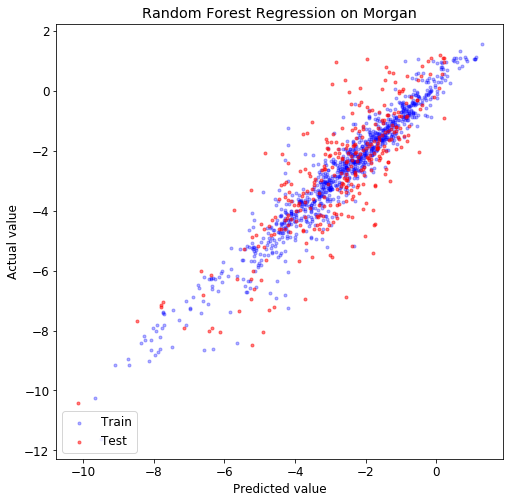

In [15]:
plt.figure(figsize=(8,8))
plt.rcParams["font.size"] = 12
plt.scatter(y_train_pred, y_train, c='blue', marker='.', alpha=0.3, label='Train')
plt.scatter(y_pred, y_test, c='red', marker='.', alpha=0.5, label='Test')
plt.xlabel('Predicted value')
plt.ylabel('Actual value')
plt.title('Random Forest Regression on Morgan')
plt.legend(loc='lower left')
#plt.hlines(y=0, xmin=1, xmax=7, lw=2, color='black')
plt.show()

In [16]:
param_grid = { "max_depth": [2,5,10, None],
                "n_estimators": [10,50,100,300],
                "max_features": [1, 3, 10],
                "min_samples_split": [2, 3, 10],
                "min_samples_leaf": [1, 3, 10]
}

In [17]:
RF_grid = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, n_jobs=8, verbose=1)
RF_grid.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    8.9s
[Parallel(n_jobs=8)]: Done 852 tasks      | elapsed:   21.5s
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:   40.6s
[Parallel(n_jobs=8)]: Done 2079 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 2160 out of 2160 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'max_depth': [2, 5, 10, None], 'min_samples_leaf': [1, 3, 10], 'n_estimators': [10, 50, 100, 300], 'min_samples_split': [2, 3, 10], 'max_features': [1, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [18]:
RF_grid.best_params_

{'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [19]:
RF_grid.best_estimator_.fit(X_train, y_train)
y_train_pred = RF_grid.best_estimator_.predict(X_train)
y_test_pred = RF_grid.best_estimator_.predict(X_test)

print('MSE train : %.3f, test : %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)) )

MSE train : 0.223, test : 1.277
R2 train : 0.946, test : 0.687


# DeepChem

In [2]:
import os
import deepchem as dc
from deepchem.models.tensorgraph.models.graph_models import GraphConvModel

In [3]:
graph_featurizer = dc.feat.graph_features.ConvMolFeaturizer()
loader = dc.data.data_loader.CSVLoader( tasks=['solubility'], smiles_field="SMILES", featurizer=graph_featurizer )
trainset = loader.featurize( '../data/sol_train.csv' )
testset = loader.featurize( '../data/sol_test.csv' )

Loading raw samples now.
shard_size: 8192
About to start loading CSV from ../data/sol_train.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 2.823 s
TIMING: dataset construction took 3.634 s
Loading dataset from disk.
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ../data/sol_test.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 0.949 s
TIMING: dataset construction took 1.159 s
Loading dataset from disk.


In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
model = GraphConvModel(n_tasks=1, graph_conv_layers=[64,64], dropout=0, batch_size=50, mode='regression')

# Epochs
model.fit(trainset, nb_epoch=50)

/home/honda/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1.441190481185913

In [12]:
metric = dc.metrics.Metric(
    dc.metrics.r2_score, np.mean, mode="regression")

print("Evaluating model")
train_scores = model.evaluate(trainset, [metric])
print("Train R2 Score: %f" % train_scores["mean-r2_score"])
test_scores = model.evaluate(testset, [metric])
print("Test R2 Score: %f" % test_scores["mean-r2_score"])

Evaluating model
computed_metrics: [0.973174331288795]
Train R2 Score: 0.973174
computed_metrics: [0.8845266039331535]
Test R2 Score: 0.884527


In [13]:
metric = dc.metrics.Metric(
    dc.metrics.mean_squared_error, np.mean, mode="regression")

print("Evaluating model")
train_scores = model.evaluate(trainset, [metric])
print("Train MSE: %f" % train_scores["mean-mean_squared_error"])
test_scores = model.evaluate(testset, [metric])
print("Test MSE: %f" % test_scores["mean-mean_squared_error"])

Evaluating model
computed_metrics: [0.11111642355590555]
Train MSE: 0.111116
computed_metrics: [0.47178782394475355]
Test MSE: 0.471788
